# Preprocess data

## Import data

In [1]:
import os
import pandas as pd

prefix_path = "./data/"

full_raw_path = prefix_path + "Train_data.csv"

cls_1_raw_path = prefix_path + "cls_1_raw.csv"
cls_2_raw_path = prefix_path + "cls_2_raw.csv"
cls_3_raw_path = prefix_path + "cls_3_raw.csv"
cls_4_raw_path = prefix_path + "cls_4_raw.csv"
cls_5_raw_path = prefix_path + "cls_5_raw.csv"
cls_raw_paths = [cls_1_raw_path,
                 cls_2_raw_path,
                 cls_3_raw_path,
                 cls_4_raw_path,
                 cls_5_raw_path]


# Check to see data has been extracted before
if all( [ os.path.exists(csv_filepath) for csv_filepath in cls_raw_paths ] ):
    
    # Load data
    cls_1_raw = pd.read_csv(cls_1_raw_path)
    cls_2_raw = pd.read_csv(cls_2_raw_path)
    cls_3_raw = pd.read_csv(cls_3_raw_path)
    cls_4_raw = pd.read_csv(cls_4_raw_path)
    cls_5_raw = pd.read_csv(cls_5_raw_path)

else:

    # Extract data into different classes
    full_df = pd.read_csv(full_raw_path, index_col=0)

    cls_1_raw = full_df[full_df['y'] == 1]
    cls_2_raw = full_df[full_df['y'] == 2]
    cls_3_raw = full_df[full_df['y'] == 3]
    cls_4_raw = full_df[full_df['y'] == 4]
    cls_5_raw = full_df[full_df['y'] == 5]

    # Write data into CSV files

    cls_1_raw.to_csv(cls_1_raw_path, index=False)
    cls_2_raw.to_csv(cls_2_raw_path, index=False)
    cls_3_raw.to_csv(cls_3_raw_path, index=False)
    cls_4_raw.to_csv(cls_4_raw_path, index=False)
    cls_5_raw.to_csv(cls_5_raw_path, index=False)

## Extract validation data
Further split data into validation and training+testing sets, if doesn't exist already.

In [2]:
from sklearn.model_selection import train_test_split
from datetime import datetime
import glob

train_test_paths = glob.glob( os.path.join(prefix_path, '*_train_test_data.csv') )
validation_paths = glob.glob( os.path.join(prefix_path, '*_validation_data.csv') )
train_test_enc_paths = glob.glob( os.path.join(prefix_path, '*_train_test_data_enc.csv') )
validation_enc_paths = glob.glob( os.path.join(prefix_path, '*_validation_data_enc.csv') )

# Create CSV files if data doesn't exist
if not train_test_paths or not validation_paths:

    # Extract 20% from each class
    cls_raw_data = [cls_1_raw,
                    cls_2_raw,
                    cls_3_raw,
                    cls_4_raw,
                    cls_5_raw]

    train_test_data = pd.DataFrame()
    validation_data = pd.DataFrame()

    for d in cls_raw_data:
        train_test, validation = train_test_split(d, test_size=0.2)
        train_test_data = pd.concat([train_test_data, train_test], ignore_index=True)
        validation_data = pd.concat([validation_data, validation], ignore_index=True)

    # Save data
    curr_time = datetime.now()
    train_test_path = "./data/" + curr_time.strftime("%m%d%y_%H%M") + "_train_test_data.csv"
    validation_path = "./data/" + curr_time.strftime("%m%d%y_%H%M") + "_validation_data.csv"

    train_test_data.to_csv(train_test_path, index=False)
    validation_data.to_csv(validation_path, index=False)

elif len(train_test_paths) == len(validation_paths) and len(train_test_paths) > 1: # check for multiple datasets

    len_prefix = len(prefix_path)

    # Sort the dates starting from latest (based on train_test_paths)
    sorted_dates = sorted( [ os.path.splitext(path)[0][len_prefix:len_prefix+11] for path in train_test_paths ], reverse=True )

    # Iterate through all the dates
    for date in sorted_dates:
        matched_val_path = [path for path in validation_paths if date in path]

        if matched_val_path: # found matching date file
            train_test_path = [path for path in train_test_paths if date in path][0] # since the dates were obtained from train_test it must exist
            validation_path = matched_val_path[0]

            # Check to see if encoded files also exist
            matched_train_test_enc = [path for path in train_test_enc_paths if date in path]
            matched_validation_enc = [path for path in train_test_enc_paths if date in path]

            try:
                train_test_enc_path = matched_train_test_enc[0]
                validation_enc_path = matched_validation_enc[0]

            except Exception as e:
                pass # no action needed, just load it later

            break

else: # load the CSV files
    train_test_path = train_test_paths[0]
    validation_path = validation_paths[0]

    train_test_val_paths = [train_test_path, validation_path]

    # Try to see if encoded files also exist
    try:
        train_test_enc_path = train_test_enc_paths[0]
        validation_enc_path = validation_enc_paths[0]

    except Exception as e:
        pass # no action needed, just load it later

    train_test_data = pd.read_csv(train_test_path)
    validation_data = pd.read_csv(validation_path)

    # Try loading 
    try:
        train_test_data_enc = pd.read_csv(train_test_enc_path)
        validation_data_enc = pd.read_csv(validation_enc_path)

    except Exception as e:
        pass # no action needed, just load it later

## Visualize data
### Visualize regular data

In [3]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

def compute_conf_bounds(cls_mean, cls_std):
    return [ np.add(cls_mean, cls_std),  np.subtract(cls_mean, cls_std) ]

def plot_five_classes(mean_lst, conf_bound_lst, fig_title):
    
    x_range = [ *range(0, len(mean_lst[0]) ) ]

    fig, ax = plt.subplots()
    fig.set_size_inches(12,9)
    
    ax.minorticks_on()
    ax.xaxis.grid()
    ax.yaxis.grid()

    ax.set_title(fig_title)

    # Plot class 1 data
    ax.fill_between(x_range, conf_bound_lst[0][0], conf_bound_lst[0][1], alpha=0.35)
    ax.plot(mean_lst[0], label='Class 1')

    # Plot class 2 data
    ax.fill_between(x_range, conf_bound_lst[1][0], conf_bound_lst[1][1], alpha=0.35)
    ax.plot(mean_lst[1], label='Class 2')

    # Plot class 3 data
    ax.fill_between(x_range, conf_bound_lst[2][0], conf_bound_lst[2][1], alpha=0.35)
    ax.plot(mean_lst[2], label='Class 3')

    # Plot class 4 data
    ax.fill_between(x_range, conf_bound_lst[3][0], conf_bound_lst[3][1], alpha=0.35)
    ax.plot(mean_lst[3], label='Class 4')

    # Plot class 5 data
    ax.fill_between(x_range, conf_bound_lst[4][0], conf_bound_lst[4][1], alpha=0.35)
    ax.plot(mean_lst[4], label='Class 5')

    ax.legend()

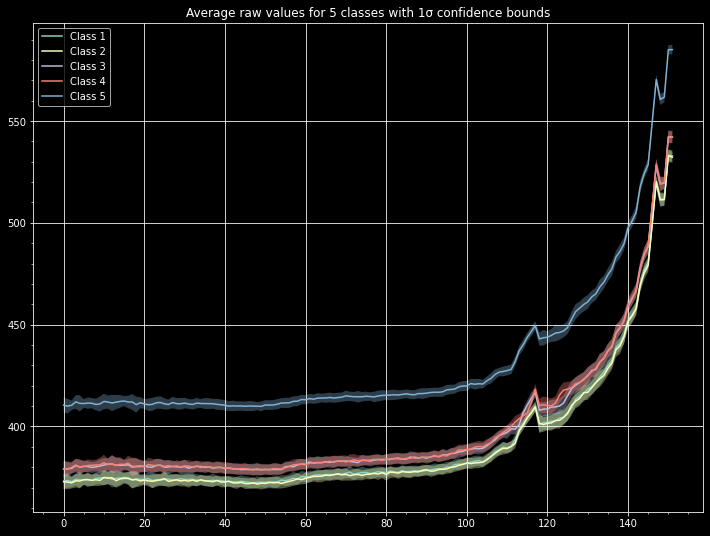

In [4]:
import numpy as np

# Compute regular averages
# train_test_data.drop(columns=train_test_data.columns[0], inplace=True) # remove index column

cls_1 = train_test_data[train_test_data['y'] == 1].drop(columns=train_test_data.columns[-1])
cls_2 = train_test_data[train_test_data['y'] == 2].drop(columns=train_test_data.columns[-1])
cls_3 = train_test_data[train_test_data['y'] == 3].drop(columns=train_test_data.columns[-1])
cls_4 = train_test_data[train_test_data['y'] == 4].drop(columns=train_test_data.columns[-1])
cls_5 = train_test_data[train_test_data['y'] == 5].drop(columns=train_test_data.columns[-1])

cls_1_mean = cls_1.mean(0).to_numpy()
cls_2_mean = cls_2.mean(0).to_numpy()
cls_3_mean = cls_3.mean(0).to_numpy()
cls_4_mean = cls_4.mean(0).to_numpy()
cls_5_mean = cls_5.mean(0).to_numpy()

cls_1_std = cls_1.std(0).to_numpy()
cls_2_std = cls_2.std(0).to_numpy()
cls_3_std = cls_3.std(0).to_numpy()
cls_4_std = cls_4.std(0).to_numpy()
cls_5_std = cls_5.std(0).to_numpy()

cls_1_conf_bounds = compute_conf_bounds(cls_1_mean, cls_1_std)
cls_2_conf_bounds = compute_conf_bounds(cls_2_mean, cls_2_std)
cls_3_conf_bounds = compute_conf_bounds(cls_3_mean, cls_3_std)
cls_4_conf_bounds = compute_conf_bounds(cls_4_mean, cls_4_std)
cls_5_conf_bounds = compute_conf_bounds(cls_5_mean, cls_5_std)

plot_five_classes([cls_1_mean, cls_2_mean, cls_3_mean, cls_4_mean, cls_5_mean],
                  [cls_1_conf_bounds, cls_2_conf_bounds, cls_3_conf_bounds, cls_4_conf_bounds, cls_5_conf_bounds],
                  "Average raw values for 5 classes with 1\u03c3 confidence bounds")


### Visualize data normalized across entire data

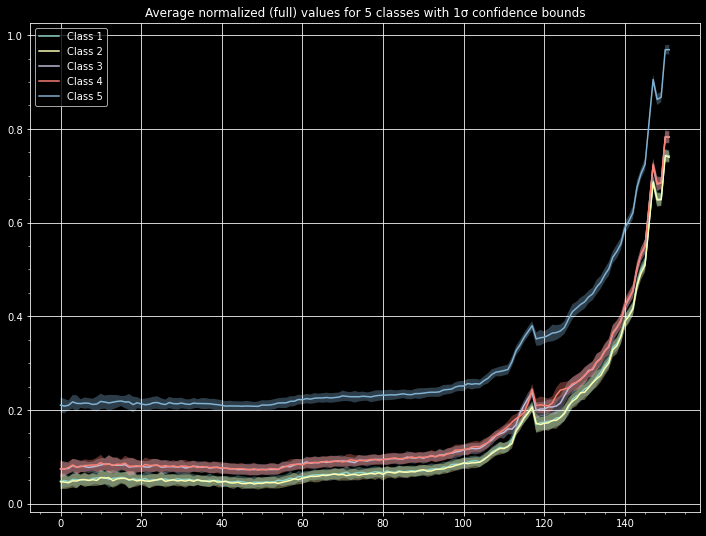

In [5]:
from util_modules import normalize

# Normalize data
train_test_data_norm_full = normalize(train_test_data.drop(columns=train_test_data.columns[-1]), "full")
train_test_data_norm_full['y'] = train_test_data.iloc[:,-1]

cls_1_norm_full = train_test_data_norm_full[train_test_data_norm_full['y'] == 1].drop(columns=train_test_data_norm_full.columns[-1])
cls_2_norm_full = train_test_data_norm_full[train_test_data_norm_full['y'] == 2].drop(columns=train_test_data_norm_full.columns[-1])
cls_3_norm_full = train_test_data_norm_full[train_test_data_norm_full['y'] == 3].drop(columns=train_test_data_norm_full.columns[-1])
cls_4_norm_full = train_test_data_norm_full[train_test_data_norm_full['y'] == 4].drop(columns=train_test_data_norm_full.columns[-1])
cls_5_norm_full = train_test_data_norm_full[train_test_data_norm_full['y'] == 5].drop(columns=train_test_data_norm_full.columns[-1])

cls_1_norm_full_mean = cls_1_norm_full.mean(0).to_numpy()
cls_2_norm_full_mean = cls_2_norm_full.mean(0).to_numpy()
cls_3_norm_full_mean = cls_3_norm_full.mean(0).to_numpy()
cls_4_norm_full_mean = cls_4_norm_full.mean(0).to_numpy()
cls_5_norm_full_mean = cls_5_norm_full.mean(0).to_numpy()

cls_1_norm_full_std = cls_1_norm_full.std(0).to_numpy()
cls_2_norm_full_std = cls_2_norm_full.std(0).to_numpy()
cls_3_norm_full_std = cls_3_norm_full.std(0).to_numpy()
cls_4_norm_full_std = cls_4_norm_full.std(0).to_numpy()
cls_5_norm_full_std = cls_5_norm_full.std(0).to_numpy()

cls_1_norm_full_conf_bounds = compute_conf_bounds(cls_1_norm_full_mean, cls_1_norm_full_std)
cls_2_norm_full_conf_bounds = compute_conf_bounds(cls_2_norm_full_mean, cls_2_norm_full_std)
cls_3_norm_full_conf_bounds = compute_conf_bounds(cls_3_norm_full_mean, cls_3_norm_full_std)
cls_4_norm_full_conf_bounds = compute_conf_bounds(cls_4_norm_full_mean, cls_4_norm_full_std)
cls_5_norm_full_conf_bounds = compute_conf_bounds(cls_5_norm_full_mean, cls_5_norm_full_std)

plot_five_classes([cls_1_norm_full_mean, cls_2_norm_full_mean, cls_3_norm_full_mean, cls_4_norm_full_mean, cls_5_norm_full_mean],
                  [cls_1_norm_full_conf_bounds, cls_2_norm_full_conf_bounds, cls_3_norm_full_conf_bounds, cls_4_norm_full_conf_bounds, cls_5_norm_full_conf_bounds],
                  "Average normalized (full) values for 5 classes with 1\u03c3 confidence bounds")

### Visualize data normalized within frequencies

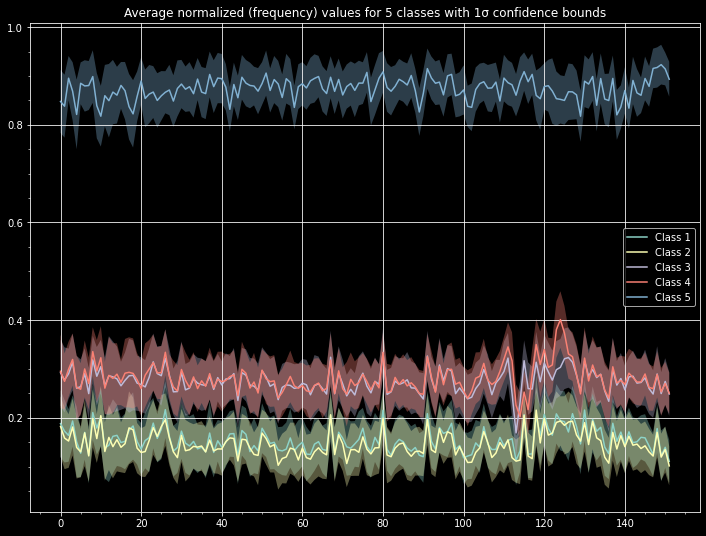

In [6]:
# Normalize data
train_test_data_norm_freq = normalize(train_test_data.drop(columns=train_test_data.columns[-1]), "freq")
train_test_data_norm_freq['y'] = train_test_data.iloc[:,-1]

cls_1_norm_freq = train_test_data_norm_freq[train_test_data_norm_freq['y'] == 1].drop(columns=train_test_data_norm_freq.columns[-1])
cls_2_norm_freq = train_test_data_norm_freq[train_test_data_norm_freq['y'] == 2].drop(columns=train_test_data_norm_freq.columns[-1])
cls_3_norm_freq = train_test_data_norm_freq[train_test_data_norm_freq['y'] == 3].drop(columns=train_test_data_norm_freq.columns[-1])
cls_4_norm_freq = train_test_data_norm_freq[train_test_data_norm_freq['y'] == 4].drop(columns=train_test_data_norm_freq.columns[-1])
cls_5_norm_freq = train_test_data_norm_freq[train_test_data_norm_freq['y'] == 5].drop(columns=train_test_data_norm_freq.columns[-1])

cls_1_norm_freq_mean = cls_1_norm_freq.mean(0).to_numpy()
cls_2_norm_freq_mean = cls_2_norm_freq.mean(0).to_numpy()
cls_3_norm_freq_mean = cls_3_norm_freq.mean(0).to_numpy()
cls_4_norm_freq_mean = cls_4_norm_freq.mean(0).to_numpy()
cls_5_norm_freq_mean = cls_5_norm_freq.mean(0).to_numpy()

cls_1_norm_freq_std = cls_1_norm_freq.std(0).to_numpy()
cls_2_norm_freq_std = cls_2_norm_freq.std(0).to_numpy()
cls_3_norm_freq_std = cls_3_norm_freq.std(0).to_numpy()
cls_4_norm_freq_std = cls_4_norm_freq.std(0).to_numpy()
cls_5_norm_freq_std = cls_5_norm_freq.std(0).to_numpy()

cls_1_norm_freq_conf_bounds = compute_conf_bounds(cls_1_norm_freq_mean, cls_1_norm_freq_std)
cls_2_norm_freq_conf_bounds = compute_conf_bounds(cls_2_norm_freq_mean, cls_2_norm_freq_std)
cls_3_norm_freq_conf_bounds = compute_conf_bounds(cls_3_norm_freq_mean, cls_3_norm_freq_std)
cls_4_norm_freq_conf_bounds = compute_conf_bounds(cls_4_norm_freq_mean, cls_4_norm_freq_std)
cls_5_norm_freq_conf_bounds = compute_conf_bounds(cls_5_norm_freq_mean, cls_5_norm_freq_std)

plot_five_classes([cls_1_norm_freq_mean, cls_2_norm_freq_mean, cls_3_norm_freq_mean, cls_4_norm_freq_mean, cls_5_norm_freq_mean],
                  [cls_1_norm_freq_conf_bounds, cls_2_norm_freq_conf_bounds, cls_3_norm_freq_conf_bounds, cls_4_norm_freq_conf_bounds, cls_5_norm_freq_conf_bounds],
                  "Average normalized (frequency) values for 5 classes with 1\u03c3 confidence bounds")

### Visualize standardized data

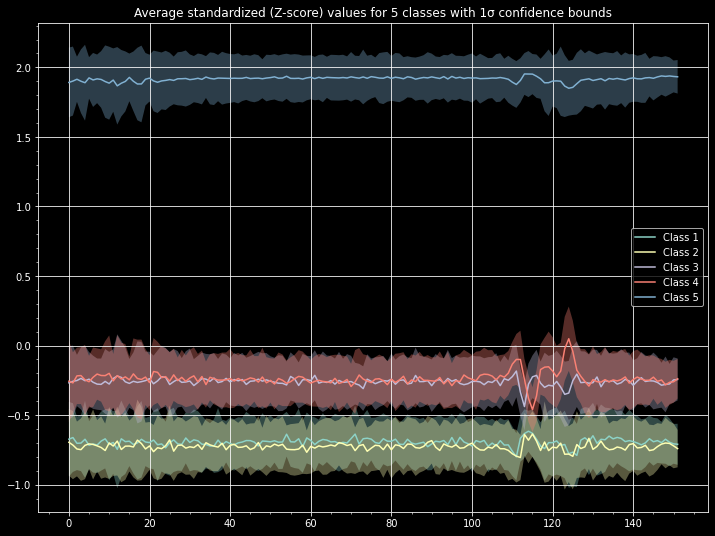

In [7]:
from util_modules import standardize

# Standardize data
train_test_data_stand = standardize(train_test_data.drop(columns=train_test_data.columns[-1]))
train_test_data_stand['y'] = train_test_data.iloc[:,-1]

cls_1_stand = train_test_data_stand[train_test_data_stand['y'] == 1].drop(columns=train_test_data_stand.columns[-1])
cls_2_stand = train_test_data_stand[train_test_data_stand['y'] == 2].drop(columns=train_test_data_stand.columns[-1])
cls_3_stand = train_test_data_stand[train_test_data_stand['y'] == 3].drop(columns=train_test_data_stand.columns[-1])
cls_4_stand = train_test_data_stand[train_test_data_stand['y'] == 4].drop(columns=train_test_data_stand.columns[-1])
cls_5_stand = train_test_data_stand[train_test_data_stand['y'] == 5].drop(columns=train_test_data_stand.columns[-1])

cls_1_stand_mean = cls_1_stand.mean(0).to_numpy()
cls_2_stand_mean = cls_2_stand.mean(0).to_numpy()
cls_3_stand_mean = cls_3_stand.mean(0).to_numpy()
cls_4_stand_mean = cls_4_stand.mean(0).to_numpy()
cls_5_stand_mean = cls_5_stand.mean(0).to_numpy()

cls_1_stand_std = cls_1_stand.std(0).to_numpy()
cls_2_stand_std = cls_2_stand.std(0).to_numpy()
cls_3_stand_std = cls_3_stand.std(0).to_numpy()
cls_4_stand_std = cls_4_stand.std(0).to_numpy()
cls_5_stand_std = cls_5_stand.std(0).to_numpy()

cls_1_stand_conf_bounds = compute_conf_bounds(cls_1_stand_mean, cls_1_stand_std)
cls_2_stand_conf_bounds = compute_conf_bounds(cls_2_stand_mean, cls_2_stand_std)
cls_3_stand_conf_bounds = compute_conf_bounds(cls_3_stand_mean, cls_3_stand_std)
cls_4_stand_conf_bounds = compute_conf_bounds(cls_4_stand_mean, cls_4_stand_std)
cls_5_stand_conf_bounds = compute_conf_bounds(cls_5_stand_mean, cls_5_stand_std)

plot_five_classes([cls_1_stand_mean, cls_2_stand_mean, cls_3_stand_mean, cls_4_stand_mean, cls_5_stand_mean],
                  [cls_1_stand_conf_bounds, cls_2_stand_conf_bounds, cls_3_stand_conf_bounds, cls_4_stand_conf_bounds, cls_5_stand_conf_bounds],
                  "Average standardized (Z-score) values for 5 classes with 1\u03c3 confidence bounds")

## Final preprocessing

### Encode data

### Shuffle and Split data for 4-fold cross validation

### Save data

In [8]:
from sklearn.utils import shuffle

# Create encoded data if not loaded earlier, then create cross validation sets
if 'train_test_data_enc' not in locals() or 'validation_data_enc' not in locals():

    # Encode training and testing data
    encoded_y_train_test = pd.get_dummies(train_test_data["y"])
    train_test_data_enc = train_test_data.drop("y", axis=1)
    train_test_data_enc = train_test_data_enc.join(encoded_y_train_test)

    # Encode validation data
    encoded_y_validation = pd.get_dummies(validation_data["y"])
    validation_data_enc = validation_data.drop("y", axis=1)
    validation_data_enc = validation_data_enc.join(encoded_y_validation)

    train_test_enc_path = train_test_path[:-4] + "_enc.csv"
    validation_enc_path = validation_path[:-4] + "_enc.csv"

    # Save the encoded data
    train_test_data_enc.to_csv(train_test_enc_path, index=False)
    validation_data_enc.to_csv(validation_enc_path, index=False)

    # Shuffle and split data for 4-fold cross validation
    train_data_dict = {"k1": [], "k2": [], "k3": [], "k4": []}
    test_data_dict = {"k1": [], "k2": [], "k3": [], "k4": []}

    # Find the length of data for each class
    len_cls = len(train_test_data_enc)/5.0
    if len_cls.is_integer(): len_cls = int(len_cls)
    else: raise Exception("Class length is not an integer!")

    # Iterate through each class
    for i in range(5):

        # Extract class data
        cls_data = train_test_data_enc.iloc[i*len_cls : (i+1)*len_cls, :].copy()
        cls_data.reset_index(inplace=True, drop=True)

        k_fold_data_size = len_cls/4
        if k_fold_data_size.is_integer(): k_fold_data_size = int(k_fold_data_size)
        else: raise Exception("K-fold data size is not an integer!")
        
        # Define indices for 4-fold cross validation data partitions
        ind_1 = 0
        ind_2 = k_fold_data_size + ind_1
        ind_3 = k_fold_data_size + ind_2
        ind_4 = k_fold_data_size + ind_3

        # Split data into partitions
        partition_1 = cls_data.iloc[ind_1:ind_2, :]
        partition_2 = cls_data.iloc[ind_2:ind_3, :]
        partition_3 = cls_data.iloc[ind_3:ind_4, :]
        partition_4 = cls_data.iloc[ind_4:, :]

        # Assign training data into 4-fold cross validation sets
        train_1 = pd.concat([partition_1.copy(), partition_2.copy(), partition_3.copy()])
        train_2 = pd.concat([partition_2.copy(), partition_3.copy(), partition_4.copy()])
        train_3 = pd.concat([partition_3.copy(), partition_4.copy(), partition_1.copy()])
        train_4 = pd.concat([partition_4.copy(), partition_1.copy(), partition_2.copy()])

        # Assign testing data into 4-fold cross validation sets
        test_1 = partition_4.copy()
        test_2 = partition_1.copy()
        test_3 = partition_2.copy()
        test_4 = partition_3.copy()

        # Store data
        train_data_dict["k1"].append(train_1)
        train_data_dict["k2"].append(train_2)
        train_data_dict["k3"].append(train_3)
        train_data_dict["k4"].append(train_4)

        test_data_dict["k1"].append(test_1)
        test_data_dict["k2"].append(test_2)
        test_data_dict["k3"].append(test_3)
        test_data_dict["k4"].append(test_4)

    # Combine and shuffle data frames for each dictionary key (i.e., k-value)
    four_fold_train_data_1 = shuffle( pd.concat( train_data_dict["k1"] ) )
    four_fold_train_data_2 = shuffle( pd.concat( train_data_dict["k2"] ) )
    four_fold_train_data_3 = shuffle( pd.concat( train_data_dict["k3"] ) )
    four_fold_train_data_4 = shuffle( pd.concat( train_data_dict["k4"] ) )

    four_fold_test_data_1 = shuffle( pd.concat( test_data_dict["k1"] ) )
    four_fold_test_data_2 = shuffle( pd.concat( test_data_dict["k2"] ) )
    four_fold_test_data_3 = shuffle( pd.concat( test_data_dict["k3"] ) )
    four_fold_test_data_4 = shuffle( pd.concat( test_data_dict["k4"] ) )

    four_fold_train_data_1.reset_index(inplace=True, drop=True)
    four_fold_train_data_2.reset_index(inplace=True, drop=True)
    four_fold_train_data_3.reset_index(inplace=True, drop=True)
    four_fold_train_data_4.reset_index(inplace=True, drop=True)

    four_fold_test_data_1.reset_index(inplace=True, drop=True)
    four_fold_test_data_2.reset_index(inplace=True, drop=True)
    four_fold_test_data_3.reset_index(inplace=True, drop=True)
    four_fold_test_data_4.reset_index(inplace=True, drop=True)

    # Save data to file
    four_fold_path_suffix_1 = "_4-fold-1.csv"
    four_fold_path_suffix_2 = "_4-fold-2.csv"
    four_fold_path_suffix_3 = "_4-fold-3.csv"
    four_fold_path_suffix_4 = "_4-fold-4.csv"

    len_prefix = len(prefix_path)

    four_fold_train_data_1.to_csv(train_test_path[:len_prefix+11] + "_train" + four_fold_path_suffix_1, index=False)
    four_fold_train_data_2.to_csv(train_test_path[:len_prefix+11] + "_train" + four_fold_path_suffix_2, index=False)
    four_fold_train_data_3.to_csv(train_test_path[:len_prefix+11] + "_train" + four_fold_path_suffix_3, index=False)
    four_fold_train_data_4.to_csv(train_test_path[:len_prefix+11] + "_train" + four_fold_path_suffix_4, index=False)

    four_fold_test_data_1.to_csv(train_test_path[:len_prefix+11] + "_test" + four_fold_path_suffix_1, index=False)
    four_fold_test_data_2.to_csv(train_test_path[:len_prefix+11] + "_test" + four_fold_path_suffix_2, index=False)
    four_fold_test_data_3.to_csv(train_test_path[:len_prefix+11] + "_test" + four_fold_path_suffix_3, index=False)
    four_fold_test_data_4.to_csv(train_test_path[:len_prefix+11] + "_test" + four_fold_path_suffix_4, index=False)